# Industry classification with sentence vec

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import LabelEncoder
from clustering_class import *
from combine_models import *
from utils import *

## Get embedding from BERT

In [2]:
cleaned_dat = pd.read_csv("clean_desc_data.csv")
cleaned_dat["intro"].str.len().quantile(q=0.7)
## set the max length of intro as 600, which coverd around 90% intro
short = cleaned_dat[cleaned_dat["intro"].str.len() <= 512]
big = cleaned_dat[cleaned_dat["intro"].str.len() > 512]
short_intro = short["intro"].values.tolist()
big_first = pd.concat([big["ticker"], big["intro"].str[:512]], axis=1)
big_second = pd.concat([big["ticker"], big["intro"].str[512:1024]], axis=1)
big_second = big_second[big_second.iloc[:, 1].str.len() > 100]
short_intro = short["intro"].values.tolist()
big_first_intro = big_first["intro"].values.tolist()
big_second_intro = big_second["intro"].values.tolist()

In [12]:
from bert import BertClient

bc = BertClient("10.0.0.2", show_server_config=True)
embadding_short = bc.encode(short_intro)
embadding_big_first = bc.encode(big_first_intro)
embadding_big_second = bc.encode(big_second_intro)

server config:
                   config_name	=	bert_config.json              
            tensorflow_version	=	['1', '10', '1']              
              http_max_connect	=	10                            
                 do_lower_case	=	True                          
                max_batch_size	=	64                            
              no_special_token	=	False                         
                   zmq_version	=	4.2.5                         
                   num_process	=	2                             
                worker -> sink	=	ipc://tmpqAy7Ff/socket        
                           cpu	=	False                         
           ventilator <-> sink	=	ipc://tmpu1KHwu/socket        
                    num_worker	=	1                             
           gpu_memory_fraction	=	1.0                           
                      port_out	=	5556                          
                     ckpt_name	=	bert_model.ckpt               
                 graph_tm

In [13]:
pd.DataFrame(embadding_short).to_csv("short_CLS_long_bert.csv")
pd.DataFrame(embadding_big_first).to_csv("first_long_CLS_long_bert.csv")
pd.DataFrame(embadding_big_second).to_csv("second_long_CLS_long_bert.csv")

## Calculate cosine similarity

In [2]:
BERT_short = pd.read_csv(
    "bert_vec_output/short_CLS_long_bert.csv", index_col=0
)
BERT_short_matrix = np.matrix(BERT_short)
cleaned_dat = pd.read_csv("data/clean_desc_data.csv")
cleaned_dat["intro"].str.len().quantile(q=0.7)
short = cleaned_dat[cleaned_dat["intro"].str.len() <= 512]
BERT_namelist = short["ticker"].values.tolist()

In [46]:
paper_cluster = paper_sim(BERT_namelist, BERT_short)
paper_cluster.paper_class=pd.read_csv('paper.csv')
paper_cluster.paper_class.columns=['id','company','paper_class']
#paper_cluster.generate_clusters(n_clusters=24, adjusted_coef=1.1)

paper_df=paper_cluster.output_clusters_df()
paper_df=paper_df[~paper_df['paper_class'].isin([13,14,15,16,17,18])]

In [6]:
official_df=pd.read_csv('data/cicslevel2.csv',dtype={'证券代码\nSecurities Code':str})
official_df.loc[official_df['交易所\nExchange']=='Shenzhen','证券代码\nSecurities Code']+='.SZ'
official_df.loc[official_df['交易所\nExchange']=='Shanghai','证券代码\nSecurities Code']+='.SH'
#official_df=official_df[['证券代码\nSecurities Code','中证一级名称\nCICS 1st Level Name']]
official_df=official_df[['证券代码\nSecurities Code','中证二级名称\nCICS 2nd Level Name']]
official_df.columns=['company','official_class']
official_df=official_df[official_df['company'].isin(BERT_namelist)]
official_df[official_df['official_class'].isin(['电信服务','食品与主要用品零售','保险'])]='其它'

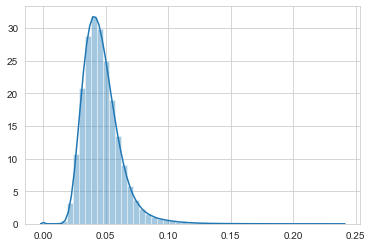

In [71]:
sns.distplot(paper_cluster.cosine_matrix)

## ML clustering algorithm

In [7]:
kmean_class=ML_clustering(BERT_short,BERT_namelist,'kmean',26)

## Identify classification effects

In [56]:
combine_class=combine_models(official_df,[paper_cluster,kmean_class])
combine_class.combine_class

,company,official_class,id,paper_class,kmean_class
0,000001.SZ,银行,1639,12,13
1,000002.SZ,房地产,849,5,4
2,000004.SZ,计算机运用,2027,21,21
3,000005.SZ,资本品,1641,12,4
4,000006.SZ,房地产,1921,20,22
...,...,...,...,...,...
2328,688333.SH,资本品,8,0,8
2329,688366.SH,医药生物,618,3,21
2330,688368.SH,半导体,1186,8,8
2331,688396.SH,半导体,1265,9,8


In [41]:
set(BERT_namelist).difference(set(paper_cluster.paper_class['company'].values.tolist()))

{'002403.SZ', '002514.SZ', '002651.SZ', '002918.SZ', '300320.SZ', '601163.SH'}

In [54]:
difflist=list(set(BERT_namelist).difference(set(paper_cluster.paper_class['company'].values.tolist())))
difflist+=paper_cluster.paper_class[~paper_cluster.paper_class['company'].isin(combine_class.combine_class['company'])]['company'].values.tolist()
elim_id=list(map(BERT_namelist.index,difflist))
shrink_matrix=np.delete(paper_cluster.cosine_matrix,elim_id,axis=0)
shrink_matrix=np.delete(shrink_matrix,elim_id,axis=1)
shrink_matrix.shape

(2333, 2333)

In [57]:
combine_class_pca=compute_pca_svd(combine_class,shrink_matrix,'pca')
combine_class_pca.combine_class

,company,official_class,id,paper_class,kmean_class,pca1,pca2
0,000001.SZ,银行,1639,12,13,-0.301387,-0.041630
1,000002.SZ,房地产,849,5,4,1.250857,0.407520
2,000004.SZ,计算机运用,2027,21,21,-0.004805,0.003153
3,000005.SZ,资本品,1641,12,4,-0.053122,-0.055779
4,000006.SZ,房地产,1921,20,22,-0.091062,0.314439
...,...,...,...,...,...,...,...
2328,688333.SH,资本品,8,0,8,-0.132297,0.098105
2329,688366.SH,医药生物,618,3,21,-0.145941,0.271307
2330,688368.SH,半导体,1186,8,8,0.594504,-0.085321
2331,688396.SH,半导体,1265,9,8,-0.593206,-0.009557


  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 36816 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\programs\Miniconda3\envs\hejj3\lib\site-

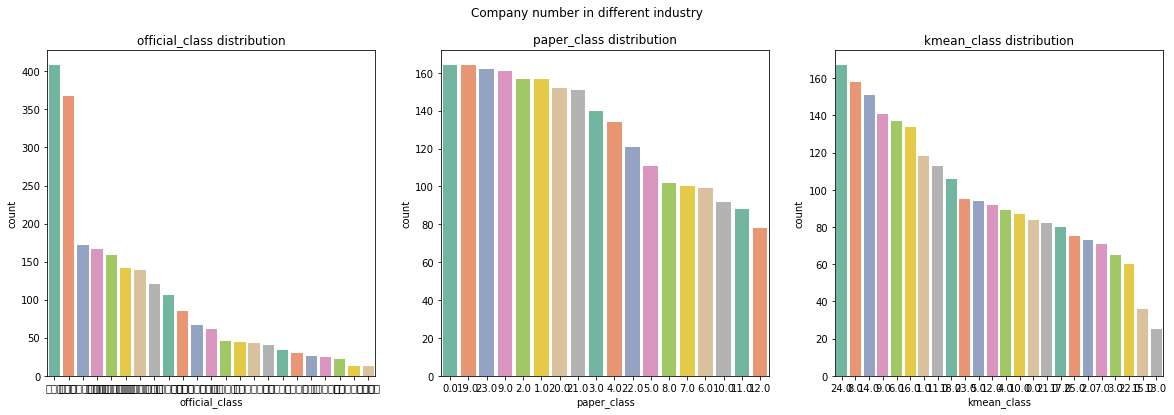

In [25]:
fig, ax= plt.subplots(1,3,figsize=(20,6))
plt.suptitle('Company number in different industry')

for i in range(3):
    sns.countplot(combine_class.combine_class[combine_class.namelist[i]],ax=ax[i],palette='Set2',order=combine_class.combine_class[combine_class.namelist[i]].value_counts().index)
    ax[i].set_title(combine_class.namelist[i]+' distribution')
plt.show()

iconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 23186 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 39135 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 39278 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 28895 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 33609 mis

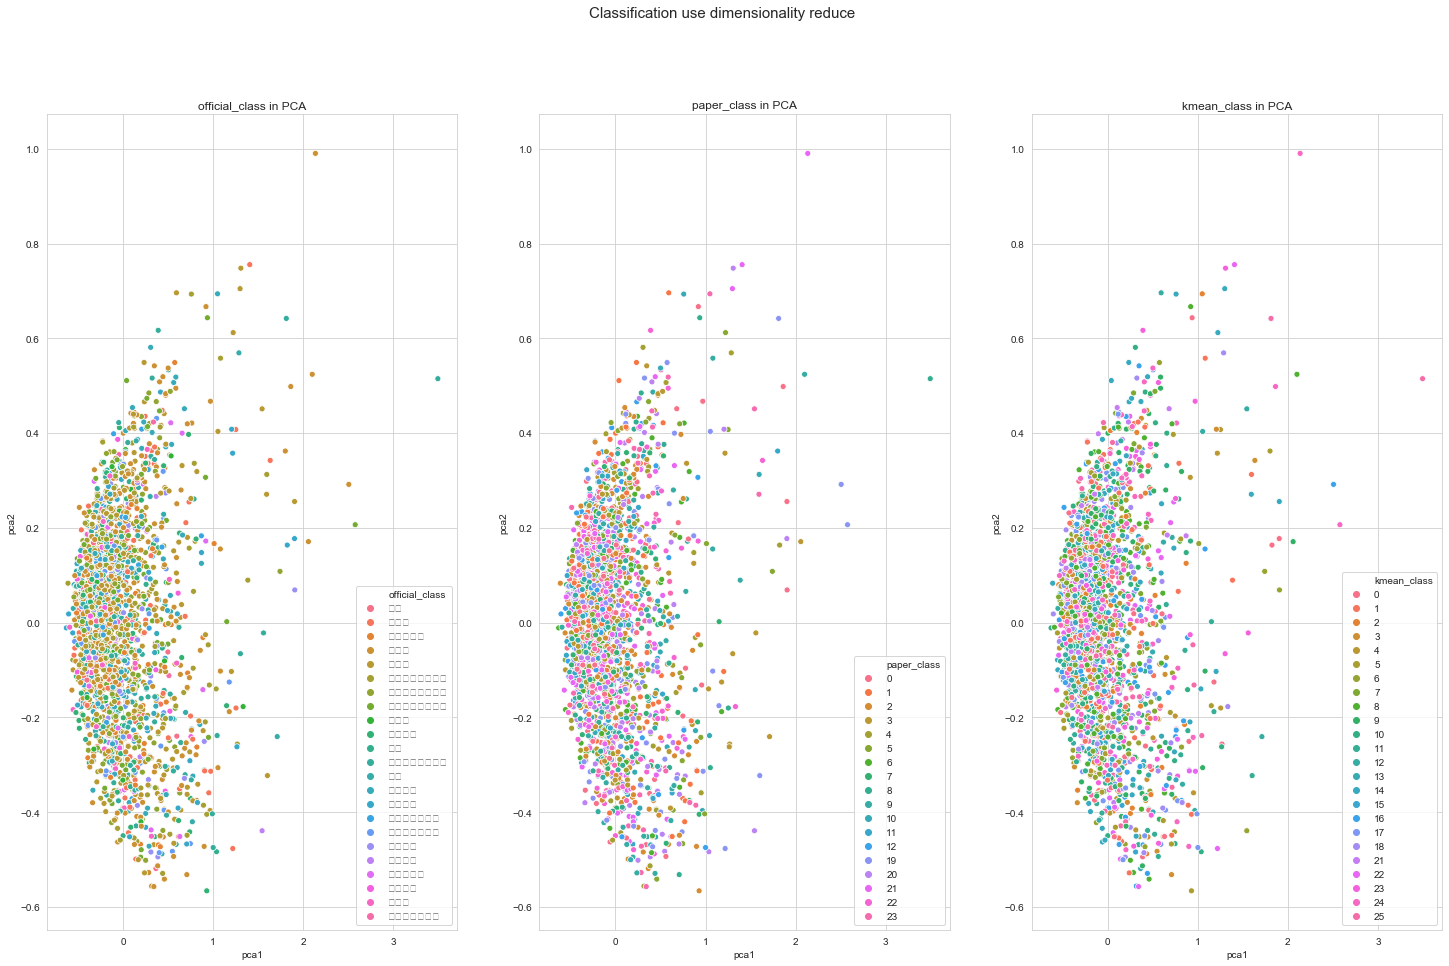

In [59]:
f,ax=plt.subplots(1,3,figsize=(25,15))
sns.set_style("whitegrid")
plt.suptitle('Classification use dimensionality reduce',fontsize=15)

for i in range(3):
    sns.scatterplot(x='pca1',y='pca2',hue=combine_class_pca.namelist[i],data=combine_class_pca.combine_class,ax=ax[i])
    ax[i].set_title(combine_class_pca.namelist[i]+' in PCA')

## Test individual return with class return

In [82]:
price_data=pd.read_csv('full stock price 20190630-20191231.csv',index_col=0)
price_data['date']=pd.to_datetime(price_data['date'],format='%Y-%m-%d')
price_data=trans_ticker(price_data)
return_data=price_data.assign(return_data=np.log(price_data.adjusted).groupby(price_data.symbol).diff())
return_data=return_data.dropna()
return_data.columns=['company','date','adjusted','return']
return_data=return_data.merge(combine_class.combine_class,on=['company'])
return_data.tail()

,company,date,adjusted,return,official_class,id,paper_class,kmean_class,pca1,pca2
281064,300626.SZ,2019-12-24,8.10,0.021211,资本品,1435,10,24,0.500192,0.537377
281065,300626.SZ,2019-12-25,8.13,0.003697,资本品,1435,10,24,0.500192,0.537377
281066,300626.SZ,2019-12-26,8.30,0.020695,资本品,1435,10,24,0.500192,0.537377
281067,300626.SZ,2019-12-27,8.30,0.000000,资本品,1435,10,24,0.500192,0.537377
281068,300626.SZ,2019-12-30,8.42,0.014354,资本品,1435,10,24,0.500192,0.537377


In [98]:
company=[i for i in combine_class.combine_class['company']]
company2ind_paper=dict(zip(combine_class.combine_class['company'],combine_class.combine_class['paper_class']))
company2ind_kmean=dict(zip(combine_class.combine_class['company'],combine_class.combine_class['kmean_class']))
company2ind_official=dict(zip(combine_class.combine_class['company'],combine_class.combine_class['official_class']))

paper_class_mean=return_data.groupby(by=['paper_class','date']).mean()['return']
kmean_class_mean=return_data.groupby(by=['kmean_class','date']).mean()['return']
official_class_mean=return_data.groupby(by=['official_class','date']).mean()['return']
                          
paper_class_return_map={i:pd.DataFrame(paper_class_mean[i,]) for i in paper_class_mean.index.levels[0]}
kmean_class_return_map={i:pd.DataFrame(kmean_class_mean[i,]) for i in kmean_class_mean.index.levels[0]}
official_class_return_map={i:pd.DataFrame(official_class_mean[i,]) for i in official_class_mean.index.levels[0]}

for i in company:
    company_class=company2ind_paper[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    paper_class_return_map[company_class]=paper_class_return_map[company_class].join(new_return)

for i in company:
    company_class=company2ind_kmean[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    kmean_class_return_map[company_class]=kmean_class_return_map[company_class].join(new_return)
    
for i in company:
    company_class=company2ind_official[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    official_class_return_map[company_class]=official_class_return_map[company_class].join(new_return)

In [99]:
for k in paper_class_return_map.keys():
    paper_class_return_map[k].dropna(1,'all',inplace=True)
paper_class_return_map[4]

,return,000404.SZ,000408.SZ,000411.SZ,000520.SZ,000548.SZ,000554.SZ,000573.SZ,000657.SZ,000697.SZ,...,603088.SH,603138.SH,603179.SH,603181.SH,603198.SH,603260.SH,603327.SH,603810.SH,603985.SH,603997.SH
date,,,,,,,,,,,,,,,,,,,,,
2019-07-02,0.000888,-0.002296,-0.014337,-0.009764,0.019972,-0.010953,0.004898,-0.005865,0.002869,0.003484,...,-0.011321,0.002166,0.015539,-0.003206,0.028458,0.000000,0.036121,0.003637,0.004966,0.000000
2019-07-03,-0.009996,-0.002301,0.009581,-0.014443,-0.028655,-0.006630,-0.016421,-0.005900,-0.020261,-0.017544,...,-0.027900,-0.018349,-0.002205,-0.001929,0.020436,-0.004357,-0.052274,-0.015946,-0.009331,-0.002532
2019-07-04,-0.002525,-0.002307,-0.048850,-0.013102,-0.002911,0.000000,-0.003317,0.005900,-0.020680,0.014060,...,0.015489,-0.012423,-0.000736,0.015326,-0.040757,-0.002081,-0.024350,0.006566,-0.010682,0.000000
2019-07-05,0.004784,0.006905,0.050041,0.012336,0.014472,0.000000,-0.010017,0.000000,0.002981,-0.013175,...,-0.004815,0.006671,0.043939,0.001267,0.025075,0.026118,0.052449,0.008342,0.003783,0.040974
2019-07-08,-0.032775,-0.037388,0.055570,-0.042260,-0.047068,-0.022422,-0.044604,-0.051293,-0.039459,-0.030523,...,-0.056591,-0.060316,0.011909,-0.019170,-0.023995,-0.039123,-0.053588,-0.027904,-0.022916,-0.053729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.013652,0.007722,0.037375,0.012621,0.000000,0.019513,0.006336,0.013245,0.037402,0.010633,...,0.012298,0.017665,0.020651,0.031290,-0.001048,0.028461,0.015876,0.004069,0.008097,0.006064
2019-12-25,0.002730,-0.002567,-0.015058,-0.007554,-0.011779,-0.002418,-0.002107,-0.006601,-0.017778,0.005753,...,0.011050,0.012887,-0.026931,0.030341,-0.004728,-0.013615,0.009558,-0.004409,0.008032,-0.018304
2019-12-26,0.008439,0.007682,-0.006920,0.010892,-0.004751,0.009639,0.014660,0.019673,0.004474,0.007619,...,0.003291,0.012723,0.021808,-0.014472,0.006822,0.009210,0.095379,0.011154,0.016529,0.036280


In [100]:
for k in kmean_class_return_map.keys():
    kmean_class_return_map[k].dropna(1,'all',inplace=True)
for k in official_class_return_map.keys():
    official_class_return_map[k].dropna(1,'all',inplace=True)

In [101]:
statistical_discribe_paper={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in paper_class_return_map.items()}
statistical_discribe_kmean={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in kmean_class_return_map.items()}
statistical_discribe_official={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in official_class_return_map.items()}

## stats.linregress return [slope, intercept, r_value, p_value, std_err]
## sum of significance is sum of the unsignificant number
## significance level: 99.9%

for i in statistical_discribe_paper:
    reg=[itemgetter(0,2,3)(stats.linregress(paper_class_return_map[i][j][paper_class_return_map[i][j].isna()==False],paper_class_return_map[i]['return'][paper_class_return_map[i][j].isna()==False])) for j in paper_class_return_map[i].columns]
    statistical_discribe_paper[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_paper[i].loc['p']=list(map(lambda x: x[2],reg))
    statistical_discribe_paper[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_paper[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_paper[i]['sum'+str(i)]=statistical_discribe_paper[i].mean(axis=1)
    statistical_discribe_paper[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_paper[i].loc['significance',]==False)
    statistical_discribe_paper[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_kmean:
    reg=[itemgetter(0,2,3)(stats.linregress(kmean_class_return_map[i][j][kmean_class_return_map[i][j].isna()==False],kmean_class_return_map[i]['return'][kmean_class_return_map[i][j].isna()==False])) for j in kmean_class_return_map[i].columns]
    statistical_discribe_kmean[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_kmean[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_kmean[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_kmean[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_kmean[i]['sum'+str(i)]=statistical_discribe_kmean[i].mean(axis=1)
    statistical_discribe_kmean[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_kmean[i].loc['significance',]==False)
    statistical_discribe_kmean[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_official:
    reg=[itemgetter(0,2,3)(stats.linregress(official_class_return_map[i][j][official_class_return_map[i][j].isna()==False],official_class_return_map[i]['return'][official_class_return_map[i][j].isna()==False])) for j in official_class_return_map[i].columns]
    statistical_discribe_official[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))    
    statistical_discribe_official[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_official[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_official[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_official[i]['sum'+str(i)]=statistical_discribe_official[i].mean(axis=1)
    statistical_discribe_official[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_official[i].loc['significance',]==False)
    statistical_discribe_official[i].drop(columns='return',inplace=True)

f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
f:\programs\Miniconda3\envs\hejj3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: Runt

In [103]:
wellness={'paper':statistical_discribe_paper,'kmean':statistical_discribe_kmean,'official':statistical_discribe_official}
wellness_summary={'paper':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'kmean':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'official':pd.DataFrame(index=['abs_slope','p','significance','R2'])}

for method in wellness_summary:
    for value in wellness[method].values():
        wellness_summary[method]=wellness_summary[method].join(value.iloc[:,-1])
    wellness_summary[method]['mean']=wellness_summary[method].mean(axis=1)
    wellness_summary[method].loc['significance','mean']=sum(wellness_summary[method].iloc[2,:-1])

wellness_summary['official']['mean']=wellness_summary['official'].iloc[:,:-1].mean(axis=1)
wellness_summary['official'].loc['significance','mean']=sum(wellness_summary['official'].iloc[2,:-1])

Mean of R square of official classification is:  0.37912570938376905
Mean of R square of kmeans classification is:  0.34203255228307183
Mean of R square of paper classification is:  0.28731648594602643


Text(0.5, 1.0, 'R square of paper classification')

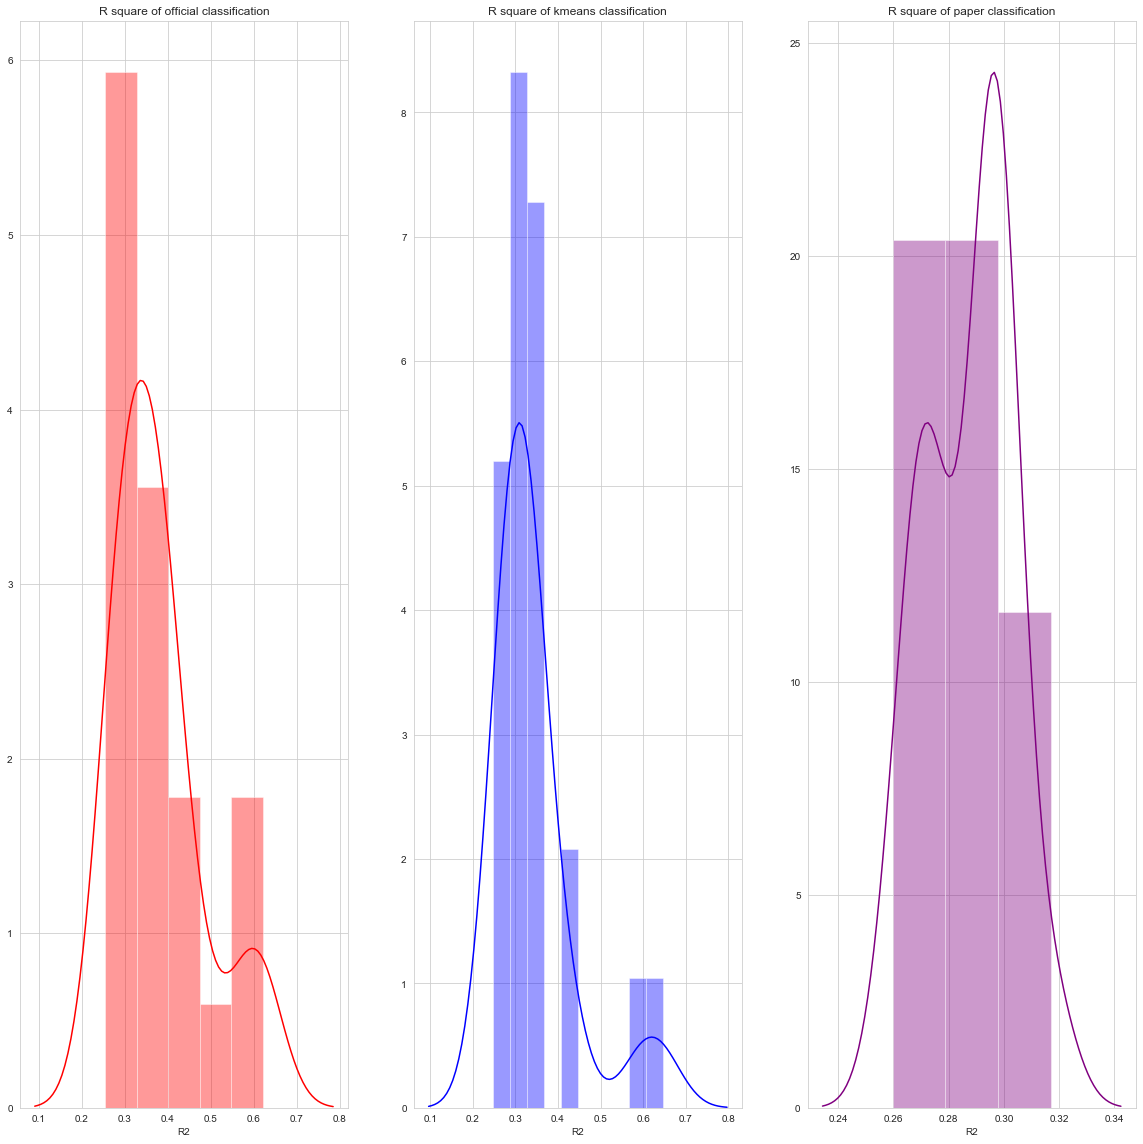

In [106]:
print('Mean of R square of official classification is: ',wellness_summary['official'].loc['R2','mean'])
print('Mean of R square of kmeans classification is: ',wellness_summary['kmean'].loc['R2','mean'])
print('Mean of R square of paper classification is: ',wellness_summary['paper'].loc['R2','mean'])
fig,ax=plt.subplots(1,3,figsize=(20,20))

sns.distplot(wellness_summary['official'].iloc[3,:-1],ax=ax[0],color='red')
ax[0].set_title('R square of official classification')
sns.distplot(wellness_summary['kmean'].iloc[3,:-1],ax=ax[1],color='blue')
ax[1].set_title('R square of kmeans classification')
sns.distplot(wellness_summary['paper'].iloc[3,:-1],ax=ax[2],color='purple')
ax[2].set_title('R square of paper classification')